## Image Classification with convolutional Neural Networks 
We are going to use CNN to allow computers to see thanks to Deep Learning. :)

### Dogs vs cats

#### Import library

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

#### Create Data Directories Train, valid , sample

In [4]:
DATA_HOME_DIR ='/home/vishnu/Documents/DeepLearningProjects/data/catsdogs/'


In [7]:
os.listdir(PATH)

['train', 'test']

In [7]:
os.listdir('train')

['cat.5774.jpg',
 'dog.2387.jpg',
 'dog.2453.jpg',
 'dog.1531.jpg',
 'cat.2659.jpg',
 'dog.6129.jpg',
 'dog.10160.jpg',
 'cat.11574.jpg',
 'dog.12257.jpg',
 'dog.7471.jpg',
 'dog.9593.jpg',
 'dog.9301.jpg',
 'dog.10322.jpg',
 'cat.12469.jpg',
 'cat.7587.jpg',
 'cat.11656.jpg',
 'dog.8414.jpg',
 'cat.5469.jpg',
 'cat.2989.jpg',
 'dog.9351.jpg',
 'cat.8356.jpg',
 'dog.4697.jpg',
 'dog.8598.jpg',
 'dog.2517.jpg',
 'cat.12368.jpg',
 'dog.7865.jpg',
 'dog.8118.jpg',
 'dog.3293.jpg',
 'cat.4016.jpg',
 'dog.3358.jpg',
 'dog.5097.jpg',
 'cat.4991.jpg',
 'cat.7717.jpg',
 'dog.11467.jpg',
 'dog.7199.jpg',
 'cat.11870.jpg',
 'cat.324.jpg',
 'dog.493.jpg',
 'dog.5269.jpg',
 'cat.1416.jpg',
 'cat.5866.jpg',
 'cat.3040.jpg',
 'dog.4530.jpg',
 'cat.4162.jpg',
 'cat.3783.jpg',
 'cat.5971.jpg',
 'dog.7740.jpg',
 'cat.8583.jpg',
 'cat.12432.jpg',
 'cat.3777.jpg',
 'dog.3313.jpg',
 'cat.112.jpg',
 'dog.333.jpg',
 'dog.1855.jpg',
 'dog.4514.jpg',
 'cat.12087.jpg',
 'cat.1499.jpg',
 'cat.10552.jpg',
 'dog.

In [12]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/vishnu/Documents/DeepLearningProjects/data/catsdogs


In [13]:
%cd $DATA_HOME_DIR/train
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(5000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

/home/vishnu/Documents/DeepLearningProjects/data/catsdogs/train


In [14]:
from shutil import copyfile
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(1000): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [15]:
%cd $DATA_HOME_DIR/valid
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(300): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

/home/vishnu/Documents/DeepLearningProjects/data/catsdogs/valid


In [16]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/vishnu/Documents/DeepLearningProjects/data/catsdogs/sample/train
/home/vishnu/Documents/DeepLearningProjects/data/catsdogs/sample/valid
/home/vishnu/Documents/DeepLearningProjects/data/catsdogs/valid
/home/vishnu/Documents/DeepLearningProjects/data/catsdogs/train


Image PReprocessing

In [17]:
size=224
batch_size=64
torch.cuda.is_available()

True

In [18]:
torch.backends.cudnn.enabled

True

look at pictures

In [19]:
os.listdir(PATH)

['train', 'results', 'test', 'valid', 'sample']

In [20]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [21]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.12469.jpg',
 'cat.12368.jpg',
 'cat.11870.jpg',
 'cat.5866.jpg',
 'cat.1499.jpg']

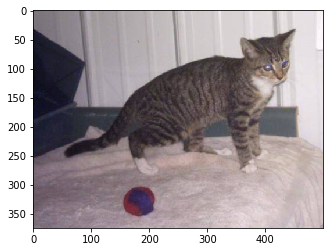

In [22]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [23]:
img.shape

(375, 499, 3)

In [24]:
img[:2,:2]

array([[[125, 118, 126],
        [124, 117, 125]],

       [[123, 116, 124],
        [123, 116, 124]]], dtype=uint8)

#### first model

In [5]:
### dataset.py

class ModelData():
    def __init__(self, path, trn_dl, val_dl, test_dl=None):
        self.path,self.trn_dl,self.val_dl,self.test_dl = path,trn_dl,val_dl,test_dl

    @classmethod
    def from_dls(cls, path,trn_dl,val_dl,test_dl=None):
        #trn_dl,val_dl = DataLoader(trn_dl),DataLoader(val_dl)
        #if test_dl: test_dl = DataLoader(test_dl)
        return cls(path, trn_dl, val_dl, test_dl)

    @property
    def is_reg(self): return self.trn_ds.is_reg
    @property
    def trn_ds(self): return self.trn_dl.dataset
    @property
    def val_ds(self): return self.val_dl.dataset
    @property
    def test_ds(self): return self.test_dl.dataset
    @property
    def trn_y(self): return self.trn_ds.y
    @property
    def val_y(self): return self.val_ds.y
    
class ImageData(ModelData):
    def __init__(self, path, datasets, bs, num_workers, classes):
        trn_ds,val_ds,fix_ds,aug_ds,test_ds,test_aug_ds = datasets
        self.path,self.bs,self.num_workers,self.classes = path,bs,num_workers,classes
        self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl,self.test_dl,self.test_aug_dl = [
            self.get_dl(ds,shuf) for ds,shuf in [
                (trn_ds,True),(val_ds,False),(fix_ds,False),(aug_ds,False),
                (test_ds,False),(test_aug_ds,False)
            ]
        ]

    def get_dl(self, ds, shuffle):
        if ds is None: return None
        return DataLoader(ds, batch_size=self.bs, shuffle=shuffle,
            num_workers=self.num_workers, pin_memory=False)

    @property
    def sz(self): return self.trn_ds.sz
    @property
    def c(self): return self.trn_ds.c

    def resized(self, dl, targ, new_path):
        return dl.dataset.resize_imgs(targ,new_path) if dl else None

    def resize(self, targ_sz, new_path='tmp'):
        new_ds = []
        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
        else: dls += [None,None]
        t = tqdm_notebook(dls)
        for dl in t: new_ds.append(self.resized(dl, targ_sz, new_path))
        t.close()
        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)

    @staticmethod
    def get_ds(fn, trn, val, tfms, test=None, **kwargs):
        res = [
            fn(trn[0], trn[1], tfms[0], **kwargs), # train
            fn(val[0], val[1], tfms[1], **kwargs), # val
            fn(trn[0], trn[1], tfms[1], **kwargs), # fix
            fn(val[0], val[1], tfms[0], **kwargs)  # aug
        ]
        if test is not None:
            if isinstance(test, tuple):
                test_lbls = test[1]
                test = test[0]
            else:
                test_lbls = np.zeros((len(test),1))
            res += [
                fn(test, test_lbls, tfms[1], **kwargs), # test
                fn(test, test_lbls, tfms[0], **kwargs)  # test_aug
            ]
        else: res += [None,None]
        return res


class ImageClassifierData(ImageData):
    @property
    def is_multi(self): return self.trn_dl.dataset.is_multi
    @classmethod
    def from_paths(cls, path, bs=64, tfms=(None,None), trn_name='train', val_name='valid', test_name=None, test_with_labels=False, num_workers=8):
        """ Read in images and their labels given as sub-folder names

        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            trn_name: a name of the folder that contains training images.
            val_name:  a name of the folder that contains validation images.
            test_name:  a name of the folder that contains test images.
            num_workers: number of workers

        Returns:
            ImageClassifierData
        """
        assert not(tfms[0] is None or tfms[1] is None), "please provide transformations for your train and validation sets"
        trn,val = [folder_source(path, o) for o in (trn_name, val_name)]
        if test_name:
            test = folder_source(path, test_name) if test_with_labels else read_dir(path, test_name)
        else: test = None
        datasets = cls.get_ds(FilesIndexArrayDataset, trn, val, tfms, path=path, test=test)
        return cls(path, datasets, bs, num_workers, classes=trn[2])

    
def folder_source(path, folder):
    fnames, lbls, all_labels = read_dirs(path, folder)
    label2idx = {v:k for k,v in enumerate(all_labels)}
    idxs = [label2idx[lbl] for lbl in lbls]
    c = len(all_labels)
    label_arr = np.array(idxs, dtype=int)
    return fnames, label_arr, all_labels

def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label not in ('.ipynb_checkpoints','.DS_Store'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels


### transforms.py

def image_gen(normalizer, denorm, sz, tfms=None, max_zoom=None, pad=0, crop_type=None,
              tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT):
    """
    Generate a standard set of transformations

    Arguments
    ---------
     normalizer :
         image normalizing function
     denorm :
         image denormalizing function
     sz :
         size, sz_y = sz if not specified.
     tfms :
         iterable collection of transformation functions
     max_zoom : float,
         maximum zoom
     pad : int,
         padding on top, left, right and bottom
     crop_type :
         crop type
     tfm_y :
         y axis specific transformations
     sz_y :
         y size, height
     pad_mode :
         cv2 padding style: repeat, reflect, etc.

    Returns
    -------
     type : ``Transforms``
         transformer for specified image operations.

    See Also
    --------
     Transforms: the transformer object returned by this function
    """
    if tfm_y is None: tfm_y=TfmType.NO
    if tfms is None: tfms=[]
    elif not isinstance(tfms, collections.Iterable): tfms=[tfms]
    if sz_y is None: sz_y = sz
    scale = [RandomScale(sz, max_zoom, tfm_y=tfm_y, sz_y=sz_y) if max_zoom is not None
             else Scale(sz, tfm_y, sz_y=sz_y)]
    if pad: scale.append(AddPadding(pad, mode=pad_mode))
    #if (max_zoom is not None or pad!=0) and crop_type is None: crop_type = CropType.RANDOM
    return Transforms(sz, scale + tfms, normalizer, denorm, crop_type, tfm_y=tfm_y, sz_y=sz_y)


transforms_basic    = [RandomRotate(10), RandomLighting(0.05, 0.05)]
transforms_side_on  = transforms_basic + [RandomFlip()]
transforms_top_down = transforms_basic + [RandomDihedral()]

imagenet_stats = A([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
"""Statistics pertaining to image data from image net. mean and std of the images of each color channel"""
inception_stats = A([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
inception_models = (inception_4, inceptionresnet_2)
"""pretrained pytorch inception models"""

def tfms_from_stats(stats, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
                    tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT):
    """ Given the statistics of the training image sets, returns separate training and validation transform functions
    """
    if aug_tfms is None: aug_tfms=[]
    tfm_norm = Normalize(*stats, tfm_y=tfm_y)
    tfm_denorm = Denormalize(*stats)
    val_crop = CropType.CENTER if crop_type==CropType.RANDOM else crop_type
    val_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=val_crop, tfm_y=tfm_y, sz_y=sz_y)
    trn_tfm=image_gen(tfm_norm, tfm_denorm, sz, tfms=aug_tfms, max_zoom=max_zoom,
                      pad=pad, crop_type=crop_type, tfm_y=tfm_y, sz_y=sz_y, pad_mode=pad_mode)
    return trn_tfm, val_tfm


def tfms_from_model(f_model, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
                    tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT):
    """ Returns separate transformers of images for training and validation.
    Transformers are constructed according to the image statistics given by the model. (See tfms_from_stats)

    Arguments:
        f_model: model, pretrained or not pretrained
    """
    stats = inception_stats if f_model in inception_models else imagenet_stats
    return tfms_from_stats(stats, sz, aug_tfms, max_zoom=max_zoom, pad=pad, crop_type=crop_type,
                       tfm_y=tfm_y, sz_y=sz_y, pad_mode=pad_mode)


##-------------------------conv_learner.py

class ConvLearner(Learner):
    """
    Class used to train a chosen supported covnet model. Eg. ResNet-34, etc.
    Arguments:
        data: training data for model
        models: model architectures to base learner
        precompute: bool to reuse precomputed activations
        **kwargs: parameters from Learner() class
    """
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi'):
            self.crit = F.binary_cross_entropy if data.is_multi else F.nll_loss
            if data.is_reg: self.crit = F.l1_loss
            elif self.metrics is None:
                self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head)
        return cls(data, models, precompute, **kwargs)


In [5]:
PATH ='/home/vishnu/Documents/DeepLearningProjects/data/catsdogs/'
image_size=299
batch_Size=32
arch=vgg16
tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_Size, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [6]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.087599   0.033478   0.988     
    1      0.077416   0.030858   0.988                        



[array([0.03086]), 0.988]

In [7]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [12]:
lrf=learn.lr_find()


 72%|███████▏  | 450/625 [00:04<00:01, 101.61it/s, loss=0.519]


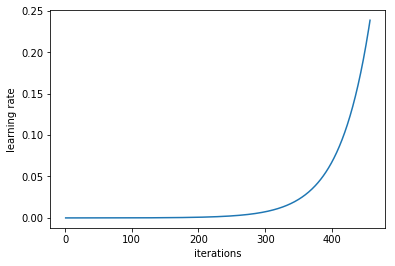

In [13]:
learn.sched.plot_lr()

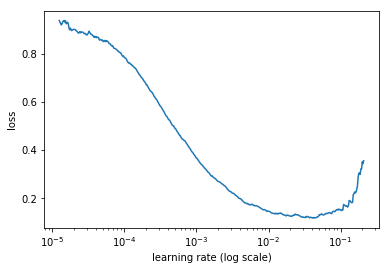

In [14]:
learn.sched.plot()

In [8]:
tfms = tfms_from_model(resnet34, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [25]:
def get_augs():
    data = ImageClassifierData.from_paths(DATA_HOME_DIR, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [26]:
ims = np.stack([get_augs() for i in range(6)])

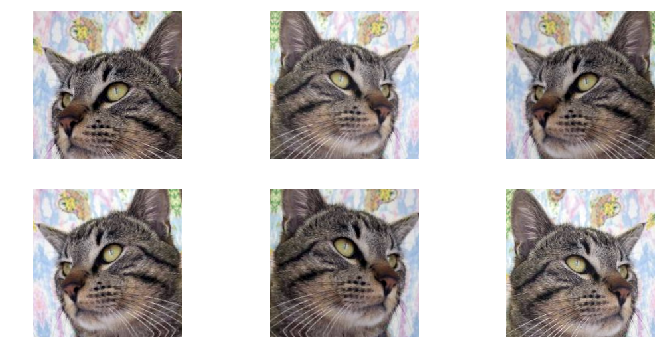

In [27]:
plots(ims, rows=2)

In [9]:
data = ImageClassifierData.from_paths(DATA_HOME_DIR, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2,1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.063582   0.033624   0.9872    



[array([0.03362]), 0.9872]

In [10]:
learn.precompute=False

In [11]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.06572    0.027901   0.9894    
    1      0.058358   0.026778   0.9906                       
    2      0.047053   0.026384   0.9906                       



[array([0.02638]), 0.9906]

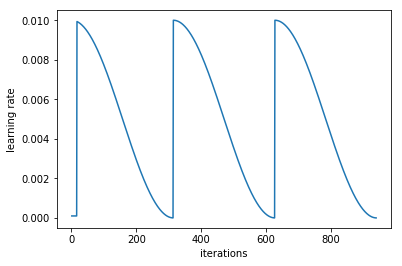

In [32]:
learn.sched.plot_lr()

In [33]:
learn.save('224_lastlayer')

In [ ]:
learn.load('224_lastlayer')

In [34]:
learn.unfreeze()

In [35]:
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.053311   0.026653   0.9908    
    1      0.033652   0.021526   0.9922                       
    2      0.034676   0.022301   0.9914                       
    3      0.035545   0.018701   0.9928                       
    4      0.023355   0.018754   0.9924                       
    5      0.019      0.019558   0.993                        
    6      0.027851   0.019794   0.993                        



[array([0.01979]), 0.993]

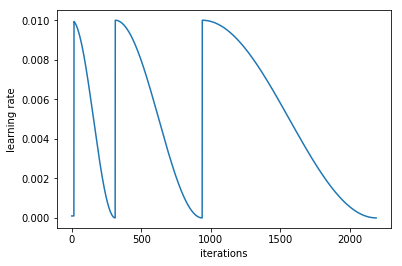

In [36]:
learn.sched.plot_lr()

In [37]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

In [38]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [39]:
accuracy_np(probs, y)

0.9942

In [40]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[2447   17]
 [  12 2524]]


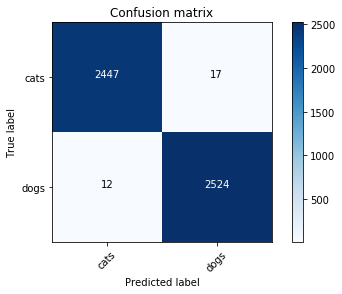

In [42]:
plot_confusion_matrix(cm, data.classes)

### Visualizing predictions

In [12]:
log_preds=learn.predict()

In [14]:
log_preds.shape

(5000, 2)

In [15]:
preds=np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])       


In [16]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [18]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [19]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))


Correctly classified


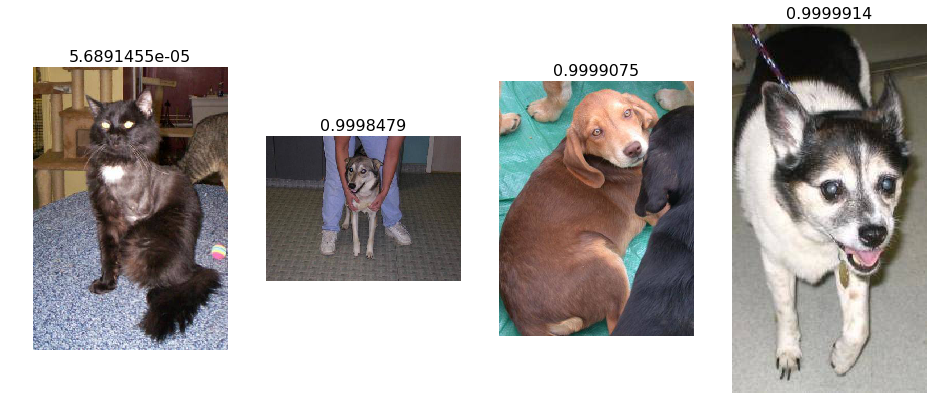

In [20]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")


Incorrectly classified


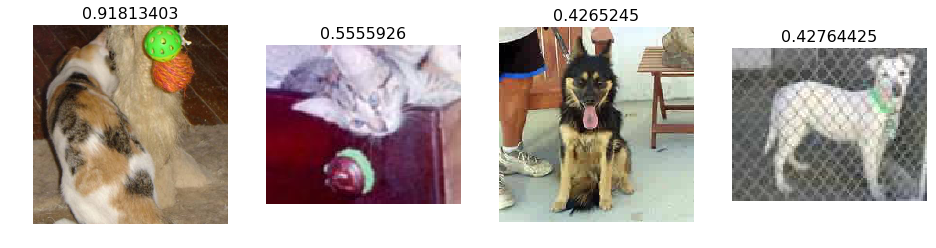

In [21]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")


In [22]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


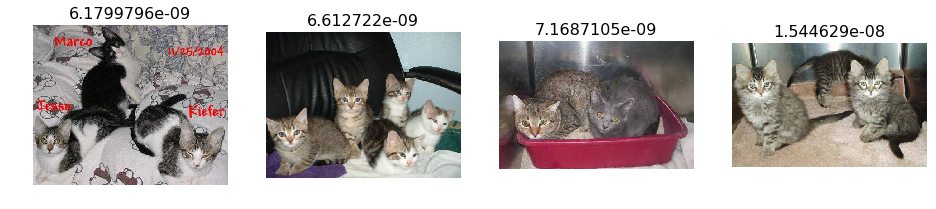

In [23]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")


Most correct dogs


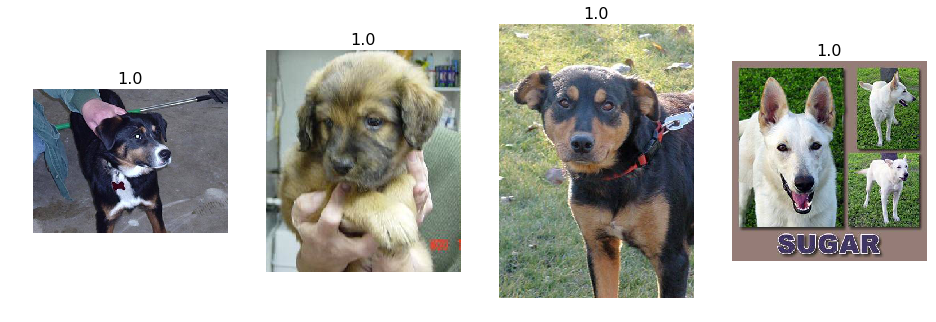

In [24]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")
